In [ ]:
!pip install -q --upgrade fastcore fastai

In [ ]:
import fastai
print(fastai.__version__ )

2.7.4


In [ ]:
from fastai.tabular.all import *

In [ ]:
import numpy as np
import pandas as pd 
import lightgbm as lgb
import gc
import math
from fastai.tabular import *
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse,mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
from tqdm import tqdm
from tqdm import tqdm_notebook

In [ ]:
def mae(y_true, y_pred):
    return mae(y_true, y_pred)

**Loading datasets from my drive using gdown:**

In [ ]:
!gdown https://drive.google.com/uc?id=1xTlto7tbQijeajjwBMFpBso-jfRsbHya
!unzip /content/layerai-air-quality-prediction-challenge.zip

Downloading...
From: https://drive.google.com/uc?id=1xTlto7tbQijeajjwBMFpBso-jfRsbHya
To: /content/layerai-air-quality-prediction-challenge.zip
100% 4.47M/4.47M [00:00<00:00, 299MB/s]
Archive:  /content/layerai-air-quality-prediction-challenge.zip
  inflating: SampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


**Reading the datasets:**

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub  = pd.read_csv('SampleSubmission.csv')

In [ ]:
train.shape, test.shape, sub.shape

((9923, 71), (4254, 70), (4254, 2))

In [ ]:
train.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,...,4181.792969,69589.453125,3181.793457,7.799846,0.278111,76.618553,9.970293,-93.110069,19.214193,63.853333
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.507083
2,ID_21L8UZQO1T,2019-12-21,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,...,4440.391113,67341.109375,3440.390869,62.496590,0.416631,-97.300758,63.690605,-127.856804,40.857922,80.290833
3,ID_GNW2G8J4T8,2020-02-20,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.601687
4,ID_4XOX2V6SK0,2019-04-17,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,...,4842.057488,64347.788635,3842.057585,4.971117,0.277157,74.786025,32.583070,-57.273638,21.864529,89.642229


In [ ]:
test.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_UOH62J0XHX,2020-10-02,aq_43,0.289040,32.589580,0.756840,23.849653,0.000124,0.839054,0.000104,...,36716.141728,8325.718024,41969.524699,7325.718482,2.632129,0.210430,74.431975,35.449770,-101.546713,21.006060
1,ID_4OPWSB0UHJ,2020-12-07,aq_54,0.356400,32.573000,0.810854,22.075347,NaN,NaN,NaN,...,63086.023438,4060.879639,70871.984375,3060.879639,2.773685,0.344436,-97.300392,63.489811,-125.937134,41.709042
2,ID_3SLMNNG1Z3,2020-11-16,aq_59,0.381576,32.647109,0.883253,20.050694,NaN,NaN,NaN,...,46783.820820,6456.160528,53084.224103,5456.160528,3.862119,0.326882,-97.699519,58.824120,-120.683819,40.183680
3,ID_MFUHTXYPM4,2020-09-05,AW66FF7V,0.379562,32.553714,0.782583,22.248958,0.000176,0.730853,0.000129,...,45528.261719,6682.570801,51503.203125,5682.570801,1.937542,0.212181,75.361595,24.835907,-72.224319,20.675266
4,ID_TY1DAND8ZP,2020-12-15,aq_45,0.344000,32.553000,0.770116,22.565217,NaN,NaN,NaN,...,65512.797785,3757.637022,73461.827324,2757.637022,3.733908,0.262021,76.537080,11.026513,-139.072620,32.046360


In [ ]:
train.isnull().sum()

ID                               0
date                             0
device                           0
site_latitude                    0
site_longitude                   0
                              ... 
Cloud_sensor_azimuth_angle    1509
Cloud_sensor_zenith_angle     1509
Cloud_solar_azimuth_angle     1509
Cloud_solar_zenith_angle      1509
pm2_5                            0
Length: 71, dtype: int64

In [ ]:
test.isnull().sum()

ID                              0
date                            0
device                          0
site_latitude                   0
site_longitude                  0
                             ... 
Cloud_surface_albedo          515
Cloud_sensor_azimuth_angle    515
Cloud_sensor_zenith_angle     515
Cloud_solar_azimuth_angle     515
Cloud_solar_zenith_angle      515
Length: 70, dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9923 entries, 0 to 9922
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID                                                        9923 non-null   object 
 1   date                                                      9923 non-null   object 
 2   device                                                    9923 non-null   object 
 3   site_latitude                                             9923 non-null   float64
 4   site_longitude                                            9923 non-null   float64
 5   humidity                                                  9923 non-null   float64
 6   temp_mean                                                 9903 non-null   float64
 7   SulphurDioxide_SO2_column_number_density                  4291 non-null   float64
 8   SulphurDioxide_SO2

In [ ]:
# covert features  fron string to List of values 
def replace_nan(x):
    if x=="nan":
        return np.nan
    else :
        return float(x)

In [ ]:
features=["humidity","temp_mean"]

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    x["p1_"+col_name]=x[col_name].apply(percentile(1))
    x["p5_"+col_name]=x[col_name].apply(percentile(5))
    x["p10_"+col_name]=x[col_name].apply(percentile(10))
    x["p20_"+col_name]=x[col_name].apply(percentile(20))
    x["p30_"+col_name]=x[col_name].apply(percentile(30))
    x["p40_"+col_name]=x[col_name].apply(percentile(40))
    x["p60_"+col_name]=x[col_name].apply(percentile(60))
    x["p70_"+col_name]=x[col_name].apply(percentile(70))
    x["p80_"+col_name]=x[col_name].apply(percentile(80))
    x["p90_"+col_name]=x[col_name].apply(percentile(90))
    x["p95_"+col_name]=x[col_name].apply(percentile(95))
    x["p99_"+col_name]=x[col_name].apply(percentile(99))
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]

In [ ]:
for col_name in tqdm(features):
    train=aggregate_features(train,col_name)
    test=aggregate_features(test,col_name)

100%|██████████| 2/2 [00:41<00:00, 20.84s/it]


In [ ]:
train[['temp_mean']].isnull().sum()

temp_mean    20
dtype: int64

In [ ]:
cols_to_fillna=["temp_mean"]                  

for i in cols_to_fillna:
    train[i].fillna(np.mean(train[i]),inplace=True)
    test[i].fillna(np.mean(test[i]),inplace=True)

In [ ]:
train.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,p10_temp_mean,p20_temp_mean,p30_temp_mean,p40_temp_mean,p60_temp_mean,p70_temp_mean,p80_temp_mean,p90_temp_mean,p95_temp_mean,p99_temp_mean
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,...,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,...,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833
2,ID_21L8UZQO1T,2019-12-21,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,...,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655
3,ID_GNW2G8J4T8,2020-02-20,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,...,16.338542,16.338542,16.338542,16.338542,16.338542,16.338542,16.338542,16.338542,16.338542,16.338542
4,ID_4XOX2V6SK0,2019-04-17,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,...,16.602083,16.602083,16.602083,16.602083,16.602083,16.602083,16.602083,16.602083,16.602083,16.602083


**Converting to datetime to use date features.**

In [ ]:
train[['date']].head()

,date
0,2020-03-18
1,2019-10-13
2,2019-12-21
3,2020-02-20
4,2019-04-17


In [ ]:
train['date'] =  pd.to_datetime(train['date'], format='%Y-%m-%d')
test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d')

**Center of the city**

In [ ]:
from geopy.geocoders import Nominatim
import time
from pprint import pprint

app = Nominatim(user_agent="tutorial")
# get location raw data
location = app.geocode("Kampala, Uganda").raw
# print raw data
pprint(location)

{'boundingbox': ['0.2143567', '0.4057676', '32.5098753', '32.6687413'],
 'class': 'boundary',
 'display_name': 'Kampala Capital City, Kampala, Central Region, Uganda',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png',
 'importance': 0.7925411725065692,
 'lat': '0.3177137',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'https://osm.org/copyright',
 'lon': '32.5813539',
 'osm_id': 10546821,
 'osm_type': 'relation',
 'place_id': 283600301,
 'type': 'administrative'}


In [ ]:
def add_center_feature(df):
    site_latitude = float(location['lat'])
    site_longitude = float(location['lon'])
    df['center_lat'] = [site_latitude] * df.shape[0]
    df['center_long'] = [site_longitude] * df.shape[0]
    return df

add_center_feature(train);
add_center_feature(test);

In [ ]:
ID_COL, TARGET_COL = 'ID', 'pm2_5'
df = pd.concat([train, test]).reset_index(drop=True)
features = [c for c in df.columns if c not in ['ID', 'date', 'pm2_5']]

In [ ]:
df['device_freq'] = df['device'].map(df['device'].value_counts())

**Checking out the City Location:**

In [ ]:
!pip install astral==2.2 --quiet

In [ ]:
import astral
from astral.sun import zenith_and_azimuth, elevation
from astral.geocoder import database, lookup
city = lookup("Kampala", database())
city

LocationInfo(name='Kampala', region='Uganda', timezone='Africa/Kampala', latitude=0.3333333333333333, longitude=32.5)

#Time Series Features
A. Using Previous and Future Target Values.
Pollution levels yesterday could tell about the pollution levels today, similary pollution levels tomorrow, could also tell about pollution levels today. We add this information to our dataset, using shift and expanding functions


In [ ]:
for i in range(1, 20):
    df[f'prev_target_{i}'] = df.sort_values(by='date')[TARGET_COL].fillna(method='ffill').shift(i).sort_index()
    df[f'next_target_{i}'] = df.sort_values(by='date')[TARGET_COL].fillna(method='bfill').shift(-i).sort_index()

for i in tqdm_notebook(range(1, 15)):
    df[f'magic_{i}'] = df.sort_values(by='date')[TARGET_COL].shift(i).expanding().mean().fillna(method='ffill').sort_index()
    df[f'magic2_{i}'] = df.sort_values(by='date')[TARGET_COL].shift(-i).expanding().mean().fillna(method='bfill').sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/14 [00:00<?, ?it/s]

#B. Cyclic Components
Date has cyclic components, for example monday repeats after every 7 days, adding this as a feature can help capture more information from the dataset.

To read more visit:

https://docs.fast.ai/tabular.transform.html#add_cyclic_datepart


In [ ]:
df['date'] = df['date'].astype('datetime64')

# # use sin and cos to capture cyclic pattern
diff = df['date'] - min(df['date'])

# # yearly pattern
days = diff.dt.days
df['year_1_sin'] = np.sin(2 * math.pi * days / (365 * 1)) 
df['year_1_cos'] = np.cos(2 * math.pi * days / (365 * 1))
df['year_2_sin'] = np.sin(2 * math.pi * days / (365 * 2)) 
df['year_2_cos'] = np.cos(2 * math.pi * days / (365 * 2)) 
df['year_3_sin'] = np.sin(2 * math.pi * days / (365 * 3)) 
df['year_3_cos'] = np.cos(2 * math.pi * days / (365 * 3)) 
df['year_4_sin'] = np.sin(2 * math.pi * days / (365 * 4)) 
df['year_4_cos'] = np.cos(2 * math.pi * days / (365 * 4)) 

# # daily pattern
seconds = diff.dt.seconds
df['day_1_sin'] = np.sin(2 * math.pi * seconds / ( 3600 * 24 * 1))
df['day_1_cos'] = np.cos(2 * math.pi * seconds / ( 3600 * 24 * 1))
df['day_2_sin'] = np.sin(2 * math.pi * seconds / ( 3600 * 24 * 2))
df['day_2_cos'] = np.cos(2 * math.pi * seconds / ( 3600 * 24 * 2))
df['day_7_sin'] = np.sin(2 * math.pi * seconds / ( 3600 * 24 * 7))
df['day_7_cos'] = np.cos(2 * math.pi * seconds / ( 3600 * 24 * 7))    

#Manhattan distnace


In [ ]:
def manhattan_distance(lat,lon):
    a = np.abs(lat -lon)
    return a
df['manhattan_dist'] = manhattan_distance(df['site_latitude'].values, df['site_longitude'].values,)

#Bearing


In [ ]:
def bearing_array(lat, lng):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lat - lng)
    lat, lng = map(np.radians, (lat, lng))
    y = np.sin(lng_delta_rad) * np.cos(lat)
    x = np.cos(lat) * np.sin(lat) - np.sin(lng) * np.cos(lng) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
df['bearing'] = bearing_array(df['site_latitude'].values, df['site_longitude'].values,)
df.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,year_4_sin,year_4_cos,day_1_sin,day_1_cos,day_2_sin,day_2_cos,day_7_sin,day_7_cos,manhattan_dist,bearing
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,...,0.999769,-0.021516,0.0,1.0,0.0,1.0,0.0,1.0,32.206858,-125.319438
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,...,0.793572,0.608477,0.0,1.0,0.0,1.0,0.0,1.0,32.191516,-125.298847
2,ID_21L8UZQO1T,2019-12-21,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,...,0.936881,0.349647,0.0,1.0,0.0,1.0,0.0,1.0,32.292575,-125.321748
3,ID_GNW2G8J4T8,2020-02-20,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,...,0.995521,0.094537,0.0,1.0,0.0,1.0,0.0,1.0,31.234221,-127.087130
4,ID_4XOX2V6SK0,2019-04-17,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,...,0.145799,0.989314,0.0,1.0,0.0,1.0,0.0,1.0,31.234221,-127.087130


# Using simple features extracted from the date itself.
Like dayofweek, weekend or not, month, days_in_month, etc.

In [ ]:
for attr in ['day', 'year', 'hour', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    df[attr] = getattr(df['date'].dt, attr)
df['is_weekend'] = (df['dayofweek'] >= 5)*1
df['fortnight'] = df['day']%15
df['3h'] = (df['hour']/ 3).astype(int)* 3  # Creating 3hours time based features
df['which_fortnight'] = df['day']//15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
df = df.drop(['date'], axis=1)

# Adding Solar azimuth, zenith and elevation features:

In [ ]:
def add_zenith_azimuth_elevation_feature(df):
    import datetime
    zen = []
    azi = []                      
    ele = []
    for i in tqdm(range(df.shape[0])):
        ze, az =  zenith_and_azimuth(city.observer, datetime.datetime(df.year[i], df.month[i], df.day[i], df.hour[i]))
        el = elevation(city.observer, datetime.datetime(df.year[i], df.month[i], df.day[i], df.hour[i]))
        zen.append(ze)
        azi.append(az)
        ele.append(el)
    df['elevation'] = ele
    df['azimuth'] = azi
    df['zenith'] = zen
    return df

add_zenith_azimuth_elevation_feature(df);

100%|██████████| 14177/14177 [00:01<00:00, 8185.86it/s]


#Adding Holiday Features:

In [ ]:
!pip install holidays --quiet
import holidays
from datetime import date

In [ ]:
def add_holiday_feature(df):
  ZA_holidays = holidays.ZA()
  list_of_holidays = [int(date(df.year[i], df.month[i], df.day[i]) in ZA_holidays) for i in range(df.shape[0])]
  df['national_holiday'] = list_of_holidays
  return df

add_holiday_feature(df)

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,is_month_end,dayofyear,is_weekend,fortnight,3h,which_fortnight,elevation,azimuth,zenith,national_holiday
0,ID_JBYXJEUZ8X,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,False,78,0,3,0,1,-59.503627,91.118398,149.503627,0
1,ID_PEJJNLBUPR,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,False,286,1,13,0,0,-53.487793,102.346188,143.487793,0
2,ID_21L8UZQO1T,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,False,355,1,6,0,1,-50.452504,128.137142,140.452504,0
3,ID_GNW2G8J4T8,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,0.000000,...,False,51,0,5,0,1,-59.173639,111.651395,149.173639,0
4,ID_4XOX2V6SK0,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,0.087338,...,False,107,0,2,0,1,-55.906514,70.885679,145.906514,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14172,ID_NYKGOYFBKZ,aq_76,0.357987,32.584100,0.786575,23.790833,NaN,NaN,NaN,NaN,...,False,238,0,10,0,1,-56.357341,69.943389,146.357341,0
14173,ID_IWO4EVLHSQ,AB6051M4,0.390741,32.582257,0.828441,21.801389,NaN,NaN,NaN,NaN,...,False,234,0,6,0,1,-56.178598,67.473870,146.178598,0
14174,ID_G1M1IMY9WU,AB6051M4,0.390741,32.582257,0.859490,21.851042,NaN,NaN,NaN,NaN,...,False,312,1,7,0,0,-50.536012,115.833724,140.536012,0
14175,ID_DXV65Q1QXI,aq_61,0.373078,32.628226,0.833803,21.948864,NaN,NaN,NaN,NaN,...,False,254,0,10,0,0,-56.386007,80.722598,146.386007,0


**Separating Train and Test sets:**

In [ ]:
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)

target = train[TARGET_COL]

In [ ]:
train.shape, test.shape

((9923, 212), (4254, 212))

In [ ]:
train.head()

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,is_month_end,dayofyear,is_weekend,fortnight,3h,which_fortnight,elevation,azimuth,zenith,national_holiday
0,ID_JBYXJEUZ8X,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,False,78,0,3,0,1,-59.503627,91.118398,149.503627,0
1,ID_PEJJNLBUPR,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,False,286,1,13,0,0,-53.487793,102.346188,143.487793,0
2,ID_21L8UZQO1T,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,False,355,1,6,0,1,-50.452504,128.137142,140.452504,0
3,ID_GNW2G8J4T8,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,0.000000,...,False,51,0,5,0,1,-59.173639,111.651395,149.173639,0
4,ID_4XOX2V6SK0,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,0.087338,...,False,107,0,2,0,1,-55.906514,70.885679,145.906514,0


In [ ]:
test.head()

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,is_month_end,dayofyear,is_weekend,fortnight,3h,which_fortnight,elevation,azimuth,zenith,national_holiday
0,ID_UOH62J0XHX,aq_43,0.289040,32.589580,0.756840,23.849653,0.000124,0.839054,0.000104,0.063487,...,False,276,0,2,0,0,-54.705783,95.886742,144.705783,0
1,ID_4OPWSB0UHJ,aq_54,0.356400,32.573000,0.810854,22.075347,NaN,NaN,NaN,NaN,...,False,342,0,7,0,0,-49.605237,125.943621,139.605237,0
2,ID_3SLMNNG1Z3,aq_59,0.381576,32.647109,0.883253,20.050694,NaN,NaN,NaN,NaN,...,False,321,0,1,0,1,-49.872542,119.536970,139.872542,0
3,ID_MFUHTXYPM4,AW66FF7V,0.379562,32.553714,0.782583,22.248958,0.000176,0.730853,0.000129,0.085770,...,False,249,1,5,0,0,-56.499584,77.247031,146.499584,0
4,ID_TY1DAND8ZP,aq_45,0.344000,32.553000,0.770116,22.565217,NaN,NaN,NaN,NaN,...,False,350,0,0,0,1,-50.024360,127.459473,140.024360,0


In [ ]:
numerical_feats= train.dtypes[train.dtypes != "object"].index; numerical_feats

Index(['site_latitude', 'site_longitude', 'humidity', 'temp_mean',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       ...
       'is_month_end', 'dayofyear', 'is_weekend', 'fortnight', '3h',
       'which_fortnight', 'elevation', 'azimuth', 'zenith',
       'national_holiday'],
      dtype='object', length=210)

In [ ]:
categorical_feats= train.dtypes[train.dtypes == "object"].index; categorical_feats

Index(['ID', 'device'], dtype='object')

In [ ]:
train.shape,test.shape

((9923, 212), (4254, 212))

In [ ]:
train.head()

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,is_month_end,dayofyear,is_weekend,fortnight,3h,which_fortnight,elevation,azimuth,zenith,national_holiday
0,ID_JBYXJEUZ8X,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,False,78,0,3,0,1,-59.503627,91.118398,149.503627,0
1,ID_PEJJNLBUPR,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,False,286,1,13,0,0,-53.487793,102.346188,143.487793,0
2,ID_21L8UZQO1T,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,False,355,1,6,0,1,-50.452504,128.137142,140.452504,0
3,ID_GNW2G8J4T8,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,0.000000,...,False,51,0,5,0,1,-59.173639,111.651395,149.173639,0
4,ID_4XOX2V6SK0,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,0.087338,...,False,107,0,2,0,1,-55.906514,70.885679,145.906514,0


#Get rid of "Highly Correlated Features":


In [ ]:
%%time
features = train.columns

num_feature = [col for col in features if col not in ['ID','pm2_5','date','device']] 
drop_columns=[]
corr = train[num_feature].corr()
# Drop highly correlated features 
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >=0.999 :
            if columns[j]:
                columns[j] = False
                print('FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(train[num_feature].columns[i] , train[num_feature].columns[j], corr.iloc[i,j]))
        elif corr.iloc[i,j] <= -0.995:
            if columns[j]:
                columns[j] = False

drop_columns = train[num_feature].columns[columns == False].values
print('drop_columns',len(drop_columns),drop_columns)

FEAT_A: site_longitude FEAT_B: bearing - Correlation: 0.9995057906894059
FEAT_A: humidity FEAT_B: max_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: min_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: mean_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: median_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p1_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p5_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p10_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p20_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p30_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p40_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p60_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p70_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p80_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p90_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p95_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p99_humidity - Correlation: 1.0
FEAT_A: temp_

In [ ]:
train.drop(drop_columns,inplace=True,axis =1)
test.drop(drop_columns,inplace=True,axis =1)

In [ ]:
train.shape, test.shape

((9923, 125), (4254, 125))

In [ ]:
train.head()

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,is_month_start,is_month_end,dayofyear,is_weekend,fortnight,3h,which_fortnight,elevation,azimuth,national_holiday
0,ID_JBYXJEUZ8X,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,False,False,78,0,3,0,1,-59.503627,91.118398,0
1,ID_PEJJNLBUPR,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,False,False,286,1,13,0,0,-53.487793,102.346188,0
2,ID_21L8UZQO1T,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,False,False,355,1,6,0,1,-50.452504,128.137142,0
3,ID_GNW2G8J4T8,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,0.000000,...,False,False,51,0,5,0,1,-59.173639,111.651395,0
4,ID_4XOX2V6SK0,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,0.087338,...,False,False,107,0,2,0,1,-55.906514,70.885679,0


In [ ]:
# list(train.columns)

**Check and remove any constant features present inside the dataset**


In [ ]:
features2 = train.columns
cols = [col for col in features2 if col not in ['ID','pm2_5','date','device']]

# Check and remove constant features
columns_to_drop = [feat for feat in train[cols] if train[feat].std() ==0]
columns_to_drop

['std_humidity',
 'var_humidity',
 'ptp_humidity',
 'std_temp_mean',
 'var_temp_mean',
 'ptp_temp_mean',
 'center_long',
 'day_1_sin',
 'day_1_cos',
 'day_2_sin',
 'day_2_cos',
 'day_7_sin',
 'day_7_cos',
 'hour',
 '3h']

In [ ]:
train.drop(columns = columns_to_drop, inplace = True)
test.drop(columns = columns_to_drop, inplace = True)

In [ ]:
train.shape, test.shape

((9923, 110), (4254, 110))

In [ ]:
train.to_csv('cleaned_train.csv', index = False)
test.to_csv('cleaned_test.csv', index = False)

In [ ]:
features = [c for c in train.columns if c not in ['ID','pm2_5','date','device']]

target = train[TARGET_COL]
len(features)

107

# Model: LGBMclassifier-v2

In [ ]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 50, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.075,
         "boosting": "gbdt",
         "feature_fraction": 0.35,
         "metric": 'auc',
         "lambda_l1": 1,
         "lambda_l2": 2,
         "random_state": 6,
         "verbosity": -1,
          'metric' : 'mae',
          'num_iterations': 1500}

target_cols = ['pm2_5']
oofs_df = pd.DataFrame()
preds_df = pd.DataFrame()
for t_col in target_cols:
    oofs_df[t_col] = np.zeros(len(train))
    preds_df[t_col] = np.zeros(len(test))

In [ ]:
max_iter = 10
folds = StratifiedKFold(n_splits=max_iter,shuffle=True,random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    print("\nfold n°{}".format(fold_))
    X_trn, X_val, X_test = train.iloc[trn_idx][features], train.iloc[val_idx][features], test[features]
    for t_col in target_cols:
        target = train[t_col]
        print(f"\n\n**** {t_col} ****\n")
        y_trn, y_val = target.iloc[trn_idx], target.iloc[val_idx]
        trn_data = lgb.Dataset(X_trn, y_trn)
        val_data = lgb.Dataset(X_val, y_val)
        
        clf = lgb.train(param, trn_data, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 200)

        oofs_df[t_col][val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
        current_test_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
        current_test_pred[current_test_pred < 0] = 0
        preds_df[t_col] += current_test_pred / folds.n_splits


fold n°0


**** pm2_5 ****



/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 6.43454	valid_1's l1: 8.27668
[100]	training's l1: 4.6079	valid_1's l1: 7.79579
[150]	training's l1: 3.55393	valid_1's l1: 7.74787
[200]	training's l1: 2.78509	valid_1's l1: 7.72643
[250]	training's l1: 2.21294	valid_1's l1: 7.74639
[300]	training's l1: 1.778	valid_1's l1: 7.76022
[350]	training's l1: 1.44059	valid_1's l1: 7.77241
Early stopping, best iteration is:
[171]	training's l1: 3.20562	valid_1's l1: 7.71585

fold n°1


**** pm2_5 ****

Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 6.32993	valid_1's l1: 8.94936
[100]	training's l1: 4.55749	valid_1's l1: 8.66677
[150]	training's l1: 3.50023	valid_1's l1: 8.67009
[200]	training's l1: 2.74191	valid_1's l1: 8.67821
[250]	training's l1: 2.18142	valid_1's l1: 8.69273
Early stopping, best iteration is:
[86]	training's l1: 4.94319	valid_1's l1: 8.64954

fold n°2


**** pm2_5 ****

Training until validation scores don't

#Feature Importances

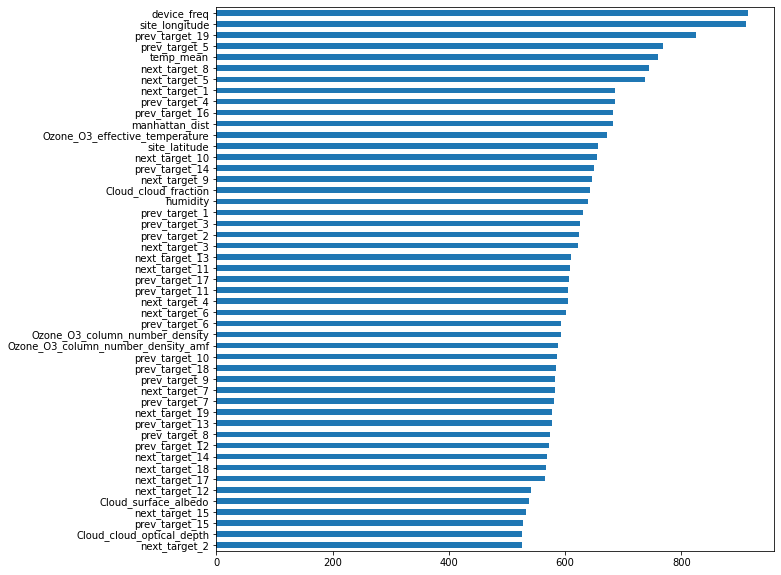

In [ ]:
_ = plt.figure(figsize=(10, 10))
fi = pd.Series(index=features, data=clf.feature_importance())
_ = fi.sort_values()[-49:].plot(kind='barh')

In [ ]:
predictions_test = preds_df['pm2_5']
predictions_test[predictions_test < 0] = 0

In [ ]:
SUB_FILE_NAME = 'airquo_lgbm_v2.csv'
sub_df = pd.DataFrame()
sub_df[ID_COL] = test[ID_COL]
sub_df[TARGET_COL] = predictions_test
sub_df.to_csv(SUB_FILE_NAME, index=False)
sub_df.head(10)

,ID,pm2_5
0,ID_UOH62J0XHX,51.290857
1,ID_4OPWSB0UHJ,81.232610
2,ID_3SLMNNG1Z3,55.441034
3,ID_MFUHTXYPM4,57.622318
4,ID_TY1DAND8ZP,67.195307
5,ID_1G270NSQ7O,67.565480
6,ID_OLV7RAEKGP,51.712371
7,ID_2JQD8OKWXK,59.499250
8,ID_3PC4T4W9JW,58.257164
9,ID_TYK7E1D8DN,56.068540
